In [2]:
import itertools
import pandas as pd
import numpy as np
from random import gauss
import warnings
import os
from functools import reduce
from data_sources import *

from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge

import matplotlib as mpl
import matplotlib.pyplot as plt

from autots.models.model_list import model_lists
from autots import AutoTS

from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.models import Prophet, ExponentialSmoothing, AutoARIMA, Theta, RegressionEnsembleModel, RegressionModel
from darts.metrics import rmse
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
import darts.metrics as dme
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.datasets import AirPassengersDataset
from darts.models import NaiveSeasonal, NaiveDrift

In [3]:
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category= FutureWarning)

# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    #  for faster iteration / execution
    cutoff = '2018-01-01'
# adjust the parameters for displayed figures
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

In [4]:
# helper functions
def my_rmse(x,y):
    return np.round(np.sqrt(mse(x, y)), 4)

<AxesSubplot:>

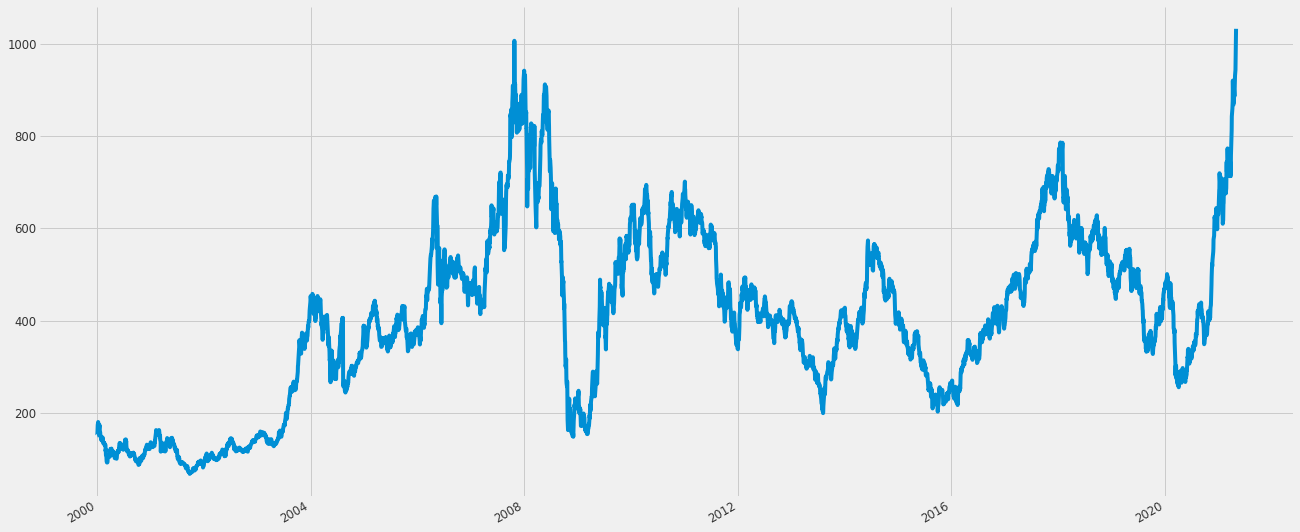

In [5]:
# load the data
stock_name = 'TATASTEEL'
df = pd.read_csv(os.path.join(data, 'nifty_50_stock_market_data_2000_2020', f'{stock_name}.csv'), usecols=['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

In [6]:
# split into training / validation
df_train, df_test = df.iloc[df.index <= '2021-01-01'], df.iloc[df.index > '2021-01-01']
print(df_train.shape, df_test.shape)

(5227, 1) (79, 1)


<a id="section-one"></a>
# AutoTS
Auto-TS is the closest we have in applying the AutoML philosophy specifically to time series. Primary features include:

- finding an optimal time series forecasting model using genetic programming optimization
- training diverse models
- data transformations
- combination of metrics for model selection

In [7]:
model_lists.keys()

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs'])

In [8]:
model_lists['all']

['ConstantNaive',
 'LastValueNaive',
 'AverageValueNaive',
 'GLS',
 'GLM',
 'ETS',
 'ARIMA',
 'FBProphet',
 'RollingRegression',
 'GluonTS',
 'SeasonalNaive',
 'UnobservedComponents',
 'VARMAX',
 'VECM',
 'DynamicFactor',
 'MotifSimulation',
 'WindowRegression',
 'VAR',
 'TFPRegression',
 'ComponentAnalysis',
 'DatepartRegression',
 'UnivariateRegression',
 'Greykite',
 'UnivariateMotif',
 'MultivariateMotif',
 'NVAR',
 'MultivariateRegression',
 'SectionalMotif',
 'Theta',
 'ARDL',
 'NeuralProphet',
 'DynamicFactorMQ',
 'PytorchForecasting',
 'ARCH']

In [9]:
model_lists['fast']

{'ConstantNaive': 1,
 'LastValueNaive': 1.5,
 'AverageValueNaive': 1,
 'GLS': 1,
 'SeasonalNaive': 1,
 'GLM': 1,
 'ETS': 1,
 'VAR': 0.8,
 'VECM': 1,
 'WindowRegression': 0.5,
 'DatepartRegression': 0.8,
 'UnivariateMotif': 1,
 'MultivariateMotif': 0.8,
 'SectionalMotif': 1,
 'NVAR': 1}

In [10]:
model_lists['superfast']

['ConstantNaive',
 'LastValueNaive',
 'AverageValueNaive',
 'GLS',
 'SeasonalNaive']

In [11]:
model_lists['probabilistic']

['ARIMA',
 'GluonTS',
 'FBProphet',
 'AverageValueNaive',
 'VARMAX',
 'DynamicFactor',
 'VAR',
 'UnivariateMotif',
 'MultivariateMotif',
 'SectionalMotif',
 'NVAR',
 'Theta',
 'ARDL',
 'UnobservedComponents',
 'DynamicFactorMQ',
 'PytorchForecasting',
 'ARCH']

In [12]:
# specify the model
model = AutoTS(
    forecast_length=len(df_test),
    frequency='infer',
    prediction_interval=0.9,
    ensemble='simple',  # select single best model
    # we want some results, but also execution in reasonable time.  GA ARE SLOW
    model_list=['GLM', 'Theta', 'ETS'],
    transformer_list="superfast",
    drop_most_recent=1,
    max_generations=5,
    num_validations=2,
    validation_method="backwards"
)

# fit the model
model = model.fit(
    df_train,
#     date_col= None, # 'datetime' if long else None,
#     value_col= None,#  'value' if long else None,
#     id_col= None,   #'series_id' if long else None,
)

Inferred frequency is: B


ImportError: cannot import name 'NDFrameT' from 'pandas._typing' (/home/noone/anaconda3/envs/time_series/lib/python3.9/site-packages/pandas/_typing.py)

In [ ]:
prediction = model.predict()  # generate prediction
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2019-01-01")  # plot a sample

In [ ]:
# Print the details of the best model
print(model)

In [ ]:
# point forecasts
forecasts_df = prediction.forecast
# upper and lower forecasts
forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast

In [ ]:
# quality of all tried model results
model_results = model.results()
model_results.head(3)

In [ ]:
# performance
my_rmse(forecasts_df, df_test.VWAP)

`AutoTS` summary:
- minimalistic setup - but tinkering possible
- cornucopia of (univariate) models
- GA is **slow**
- very much beta version